## Word2Vec mini demo

![](./img/word2vec-model.jpg)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
dtype = torch.FloatTensor

In [3]:
sentences = [ "i like dog", "i like cat", "i like animal",
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie book music like", "cat dog hate", "cat dog like"]
# 实际的例子： 
#sentences = [ "i like dog", 
#              "i love cat", 
#              "i like animal",
#              "i love xr",
#              "i love you",
#             ]

In [4]:
word_sequence = " ".join(sentences).split()
word_set = list(set(word_sequence))
word_dict = {w:i for i,w in enumerate(word_set)}

In [5]:
# 制作skip-gram数据

# 方法1: 参考方法，contex有问题：两句话之间不应该被连在一起
skip_grams1 = []
for i in range(1,len(word_sequence)-1):
    target = word_dict[word_sequence[i]]
    # 这个contex采集有问题，两句话之间不应该被连在一起
    contex = [word_dict[word_sequence[i-1]],word_dict[word_sequence[i+1]]]
    for w in contex:
        skip_grams1.append([target, w])

# 方法2: 只在一个句子中采集contex      
skip_grams2 = []
for s in sentences:
    words = s.split()
    for i in range(len(words)-1):
        target = word_dict[words[i]]
        contex = word_dict[words[i+1]]
        # 正反序都要
        skip_grams2.append([target,contex])
        skip_grams2.append([contex,target])
        
print(word_dict)
print([10,4]  in skip_grams1)
print([10,4]  in skip_grams2)

{'animal': 0, 'like': 1, 'book': 2, 'fish': 3, 'hate': 4, 'dog': 5, 'apple': 6, 'cat': 7, 'milk': 8, 'i': 9, 'movie': 10, 'music': 11, 'eyes': 12}
False
False


In [6]:
# word2vec参数
voc_size = len(word_dict)
embedding_size = 2  # 可调参数
batch_size = 20 # 训练参数

In [7]:
# data：skip_gram
# size: batch_size
# return: list[]
def random_batch(data,size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        data_in = np.eye(voc_size)[data[i][0]]
        data_target = data[i][1]
        random_inputs.append(data_in)
        random_labels.append(data_target)
    return random_inputs,random_labels

In [8]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec,self).__init__()
        self.W = nn.Parameter(torch.randn(voc_size, embedding_size)).type(dtype)
        self.WT = nn.Parameter(torch.randn(embedding_size, voc_size)).type(dtype)
    
    def forward(self, X):
        # X: [batch_size, voc_size] 后者是onehot向量
        # [batch_size, voc_size] * [voc_size, embedding_size] = [batch_size, embedding_size]
        hidden = torch.mm(X,self.W)
        
        # [batch_size, embedding_size] * [embedding_size, voc_size] = [batch_size, voc_size]
        output = torch.mm(hidden, self.WT)
        return output

In [9]:
model = Word2Vec()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 5001
for e in range(epochs):
    # 这里用第二种获取skip-gram的方法
    in_batch, target_batch = random_batch(skip_grams2,batch_size)
    in_batch = Variable(torch.Tensor(in_batch)) # 注意数据类型
    target_batch = Variable(torch.LongTensor(target_batch))
    optimizer.zero_grad()
    output = model(in_batch)
    loss = criterion(output, target_batch)
    
    if (e + 1)%1000 == 0:
        print('Epoch:', '%04d' % (e + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 2.246277
Epoch: 2000 cost = 1.892726
Epoch: 3000 cost = 1.451808
Epoch: 4000 cost = 1.558031
Epoch: 5000 cost = 1.801924


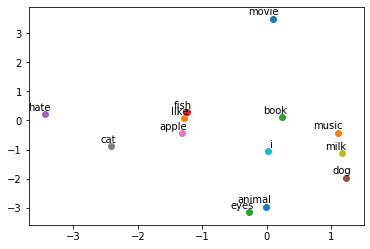

In [12]:
# 可视化
import matplotlib.pyplot as plt
W,WT = model.parameters()
for word_str in word_dict:
    word_index = word_dict[word_str]
    word_embedding = W[word_index]
    x = float(word_embedding.data[0])
    y = float(word_embedding.data[1])
    plt.scatter(x, y)
    plt.annotate(word_str, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()    

### Reference

* [ nlp-tutorial](https://github.com/graykode/nlp-tutorial)